In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
SEED_NUM = 13
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [23]:
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
         'vocab_size' : prepro_configs['vocab_size'],
         'embedding_size' : 128,
         'num_filters' : 100,
         'dropout_rate' : 0.5,
         'hidden_dimension' : 250,
         'output_dimension' : 1}

In [24]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                          output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                            kernel_size=kernel_size,
                            padding='valid',
                            activation=tf.keras.activations.relu,
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
            for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                    activation=tf.keras.activations.relu,
                    kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                    activation=tf.keras.activations.sigmoid,
                    kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
    
        return x

In [25]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [26]:
earlystop_callback = EarlyStopping(monitor='val_accuracy',
                                   min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor = 'val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=True)

./data_out/cnn_classifier_en -- Folder already exists 



In [27]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
44/44 [==============================] - 26s 581ms/step - loss: 0.6878 - accuracy: 0.5574 - val_loss: 0.5434 - val_accuracy: 0.7884

Epoch 00001: val_accuracy improved from -inf to 0.78840, saving model to ./data_out/cnn_classifier_en/weights.h5
Epoch 2/5
44/44 [==============================] - 25s 576ms/step - loss: 0.4298 - accuracy: 0.8170 - val_loss: 0.3029 - val_accuracy: 0.8732

Epoch 00002: val_accuracy improved from 0.78840 to 0.87320, saving model to ./data_out/cnn_classifier_en/weights.h5
Epoch 3/5
44/44 [==============================] - 24s 557ms/step - loss: 0.2214 - accuracy: 0.9153 - val_loss: 0.2863 - val_accuracy: 0.8868

Epoch 00003: val_accuracy improved from 0.87320 to 0.88680, saving model to ./data_out/cnn_classifier_en/weights.h5
Epoch 4/5
44/44 [==============================] - 25s 572ms/step - loss: 0.1279 - accuracy: 0.9561 - val_loss: 0.3302 - val_accuracy: 0.8820

Epoch 00004: val_accuracy did not improve from 0.88680
Epoch 5/5
44/44 [===========

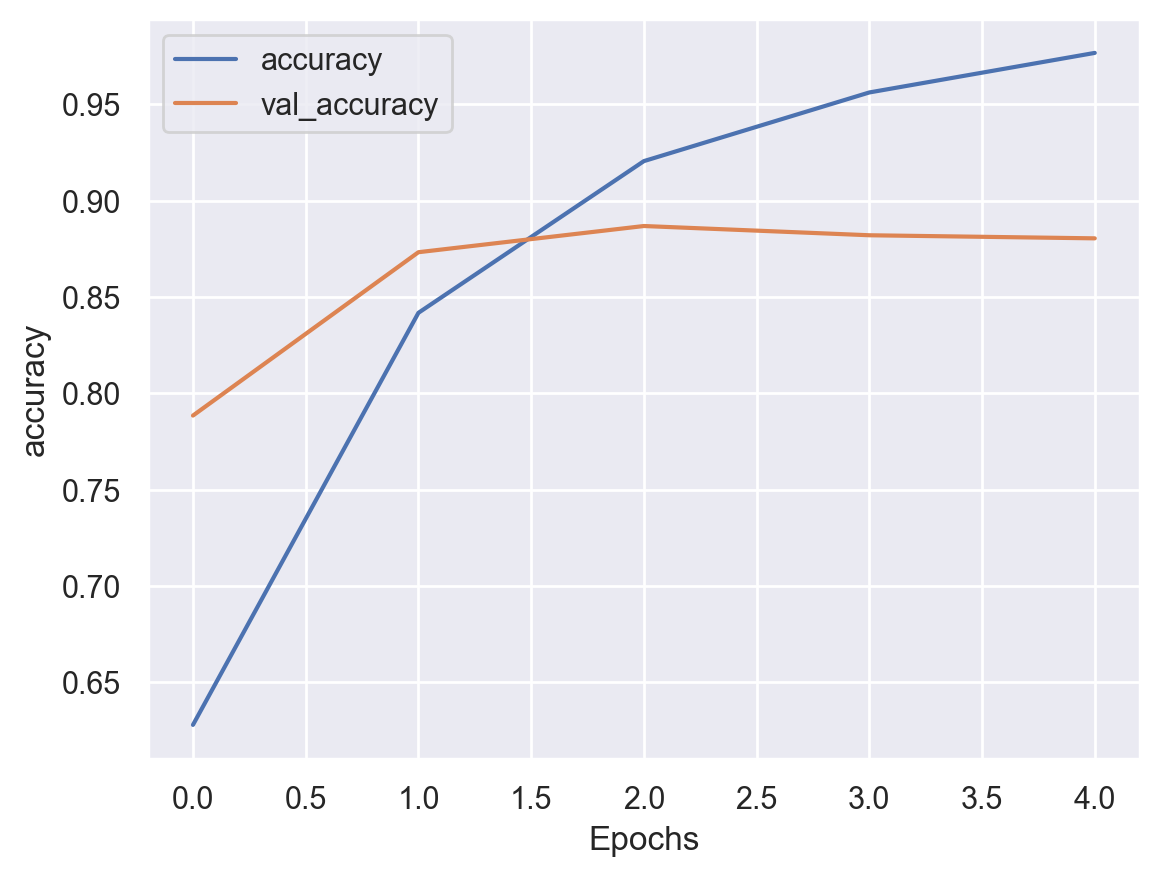

In [28]:
plot_graphs(history, 'accuracy')

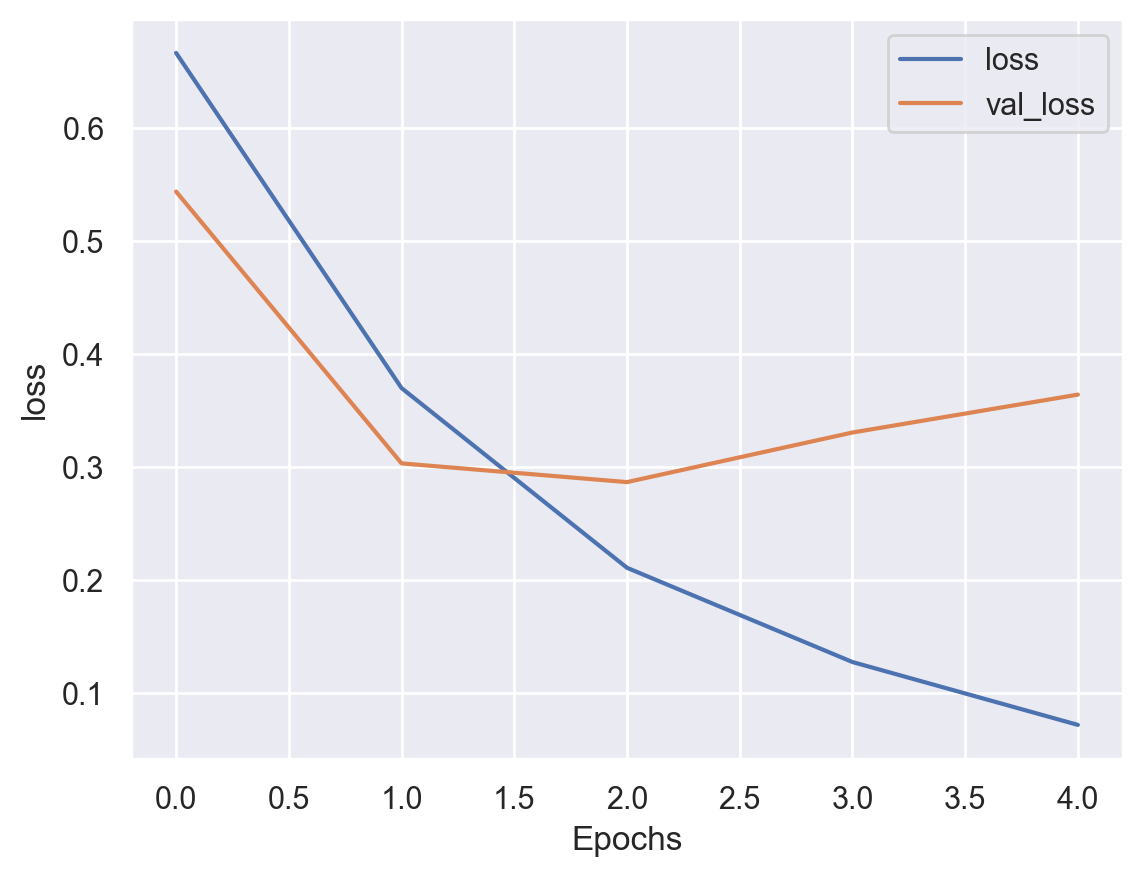

In [29]:
plot_graphs(history, 'loss')

In [30]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [31]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights('./data_out/cnn_classifier_en/weights.h5')

In [32]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [33]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={'id' : list(test_id), 'sentiment':list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False,
              quoting=3)